# Notebook 2: Improvements on the Initial Fit #

I this notebook, the following steps are taken:
- Fit a second model for comparison with the first model.
- Compute and save predictions on the training and validation data for both models that contain the original prediction values as floats
- Examine the effects of different cutoff values on the classification metrics.
- Make final recommendations for the current models and choose a model and cutoff for use in a streamlit app
- Discuss future directions for this project.

In [1]:
# Common data science imports used in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import classification_report

# Basic Python libraries used in this notebook
import time
import datetime
import os
import json

# A custom script I wrote to easily calculate and display classification metrics
import metrictools_snow as mts

# Tensorflow libraries for importing and preprocessing images
from tensorflow import io
from tensorflow import strings
from tensorflow import argmax
from tensorflow.data import AUTOTUNE
from tensorflow.data import Dataset
from tensorflow.image import resize_with_pad

# Building neural nets and loading saved models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

The three cells below are copied exactly from the beginning of Notebook 1.  The image import process is the same as the process used there.  In the future, this process may be converted to a script to reduce repetition.

In [3]:
def get_image(file_path):
    
    # Given a Tensorflow filepath object, sets label to 0 if the second to last part of the path is 'clear' and 1 if it is 'snow'.
    parts = strings.split(file_path, os.path.sep)
    label = parts[-2] == ['clear', 'snow']
    
    # Reads in the image at the given filepath, which should be a jpeg.
    img = io.read_file(file_path)
    img = io.decode_jpeg(img)
    
    # Add buffer as necessary to resize image to 640x640 without changing aspect ratio.
    # 640 is the largest dimesion of any image in the dataset.
    img = resize_with_pad(img, 640, 640)
    
    # Normalize images so each pixel is in the range -1 to 1
    return (img - 127.5) / 127.5, argmax(label)

In [4]:
def get_data(img_folder_list, shuffle_seed, train_size=0.8):
    
    # Gets paths to all the files in the given folders holding the training data.  No shuffling is done yet.
    file_groups = [Dataset.list_files(folder+'*', shuffle=False) for folder in img_folder_list]
    
    # Will not run unless at least 2 data folders are passed, as folder names are used to determine image labels.
    if len(file_groups) > 1:
    
        # Join the filepaths from each folder into one variable.
        for i in range(1, len(file_groups)):
            image_paths = file_groups[0].concatenate(file_groups[i])

        # Filepaths are now shuffled.  This will be redone for each training epoch.
        # It's important to do the shuffling now, before images are read into memory.
        image_paths = image_paths.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True, seed=shuffle_seed)
    
        # Train/Test/Split based on train_size, which gives the proportion of images that should be used for training.
        train_paths = image_paths.take(int(len(image_paths)*train_size))
        val_paths = image_paths.skip(int(len(image_paths)*train_size))
    
        # Use the get_image function import the images, which are resized and normalized as they are imported.
        train_images = train_paths.map(get_image, num_parallel_calls=AUTOTUNE)
        val_images = val_paths.map(get_image, num_parallel_calls=AUTOTUNE)
        return train_images, val_images
    
    # If fewer than 2 folders were given, print the message below and return no data.
    else:
        print('Only one class found.  No data returned.')
        return None

In [5]:
# Execute the above functions to create Tensorflow Dataset objects for training.
folders = ['../data/train/clear/', '../data/train/snow/']
train_data, val_data = get_data(folders, shuffle_seed=632, train_size=0.8)

### Section VI: Train a Second Neural Net: model2 ###

Although the neural net trained in Notebook 1, test1, performed very well, I noticed while designing the streamlit app that it seemed to struggle to recognize more realistic pictures of falling snow, especially when the snow was wet or the flakes were small.  I'm training a new neural net with slightly smaller convolution kernels and larger MaxPooling kernels to try to highlight those smaller snowflakes.  I'm also allowing the model to train for 10 epochs, rather than 5.

A more proper gridsearch process would certainly be helpful, but would also be quite time-consuming, even with CUDA.  The original model already performed very well on the synthetic snow images in this dataset.  The problem of identifying wet or light snowfall may need to be addressed by training on a dataset containing more realistic snow pictures.  These considerations will be addressed as possibilities for future work in the Conclusions.

In [6]:
# Save an unbatched version of the data, which will make it easier to generate predictions and calculate metrics with them.
train_data_unbatched = train_data
val_data_unbatched = val_data

# Create batches for training and tell Tensorflow to fetch the next batch while each batch is being fit.
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [6]:
model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(4, 4),
                        strides=(2, 2),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(4, 4)))

model.add(layers.Conv2D(filters=8, kernel_size=(4, 4),
                       strides=(2, 2),
                       activation='leaky_relu',
                       padding='same'))

model.add(layers.MaxPooling2D(pool_size=(4, 4)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='leaky_relu'))

model.add(layers.Dense(8, activation='leaky_relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [8]:
history = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10
2500/2500 [==============================] - 282s 112ms/step - loss: 0.1462 - accuracy: 0.9402 - val_loss: 0.0660 - val_accuracy: 0.9780
Epoch 2/10
2500/2500 [==============================] - 295s 118ms/step - loss: 0.0693 - accuracy: 0.9751 - val_loss: 0.0865 - val_accuracy: 0.9672
Epoch 3/10
2500/2500 [==============================] - 294s 118ms/step - loss: 0.0533 - accuracy: 0.9813 - val_loss: 0.0492 - val_accuracy: 0.9830
Epoch 4/10
2500/2500 [==============================] - 294s 117ms/step - loss: 0.0460 - accuracy: 0.9842 - val_loss: 0.0395 - val_accuracy: 0.9856
Epoch 5/10
2500/2500 [==============================] - 293s 117ms/step - loss: 0.0382 - accuracy: 0.9867 - val_loss: 0.0382 - val_accuracy: 0.9857
Epoch 6/10
2500/2500 [==============================] - 292s 117ms/step - loss: 0.0355 - accuracy: 0.9872 - val_loss: 0.0256 - val_accuracy: 0.9904
Epoch 7/10
2500/2500 [==============================] - 292s 117ms/step - loss: 0.0331 - accuracy: 0.9880 - val_

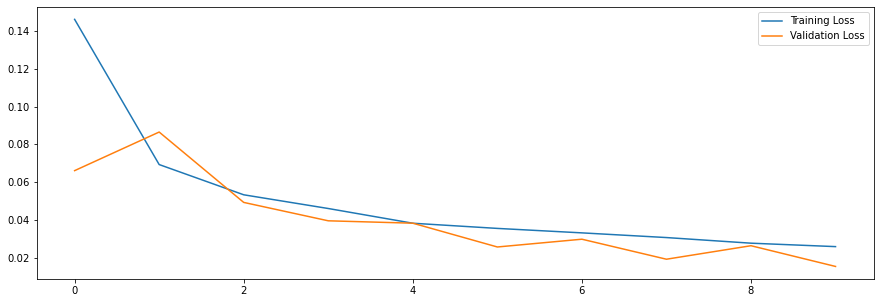

In [9]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

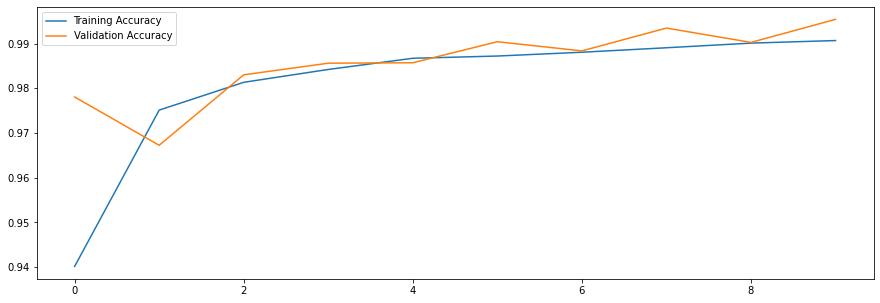

In [10]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

These plots show the loss and accuracy scores of the model after each epoch (numbered from 0 to 9).  This model also performs extremely well.  It achieves very low loss and high accuracy while remaining slightly underfit.  It is possible that it could improve even further with more training epochs.  Both loss and accuracy still seem to be improving.

### Section VII: Save model2 and Save Predictions from Both Models as Floats ###

Model and training history saved according to the same process as in Notebook 1.

In [11]:
model_name = 'model2'

In [12]:
model.save(f'../saved_models/{model_name}')

INFO:tensorflow:Assets written to: ../saved_models/model2\assets


In [13]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}_hist', 'w'))

The process of saving predictions is identical to that used in Notebook 1, except that I now save the raw predictions to csv as floats, rather than rounding and converting to int first.  This allows for later adjustment of the threshold for identifying an image as having snow.

I also improved get_preds to take the model as an argument, rather than hard-coding it into the function.

In [22]:
def get_preds(dataset, model, model_name, which_data):

    # Generating predictions on the data takes a while, so updates will be printed.
    # t_start saves the time that prediction generation began so the updates can include time elapsed.
    t_start = time.time()
    # Count and total are also used to inform the user of progress.
    count = 0
    total = len(dataset)
    
    preds = np.array([])
    true = np.array([])
    # Iterate through each image in the given dataset and corresponding label.
    for image, label in dataset:
        # Save the predicted and true label for each image in a numpy array.        
        preds = np.concatenate([preds, np.array([float(model.predict(image[np.newaxis, :]))])])
        true = np.concatenate([true, np.array([label.numpy()])])
        count += 1
        # Update the user after every 1000 predictions.
        if count % 1000 == 0:
            print(f'Calculated {count} of {total} predictions ({round(count * 100 / total, 2)}%) for {which_data} data. '
                  f'{datetime.timedelta(seconds=time.time()-t_start)} elapsed.')
    
    # Save the predictions and labels to a dataframe and then output them to a csv.
    df = pd.DataFrame(zip(true, preds), columns=['true', 'pred'])
    df.to_csv(f'../saved_models/{model_name}_{which_data}.csv', index=False)   
    
    # Return the predictions and labels in numpy arrays.
    return preds, true

In [23]:
# Obtain predictions and labels for validation data.
val_preds, val_true = get_preds(val_data_unbatched, model, model_name, 'val')

Calculated 1000 of 20000 predictions (5.0%) for val data. 0:00:50.717702 elapsed.
Calculated 2000 of 20000 predictions (10.0%) for val data. 0:01:38.899550 elapsed.
Calculated 3000 of 20000 predictions (15.0%) for val data. 0:02:28.999362 elapsed.
Calculated 4000 of 20000 predictions (20.0%) for val data. 0:03:18.693809 elapsed.
Calculated 5000 of 20000 predictions (25.0%) for val data. 0:04:08.705441 elapsed.
Calculated 6000 of 20000 predictions (30.0%) for val data. 0:04:58.377130 elapsed.
Calculated 7000 of 20000 predictions (35.0%) for val data. 0:05:48.112289 elapsed.
Calculated 8000 of 20000 predictions (40.0%) for val data. 0:06:37.923380 elapsed.
Calculated 9000 of 20000 predictions (45.0%) for val data. 0:07:27.755879 elapsed.
Calculated 10000 of 20000 predictions (50.0%) for val data. 0:08:17.473757 elapsed.
Calculated 11000 of 20000 predictions (55.0%) for val data. 0:09:07.171202 elapsed.
Calculated 12000 of 20000 predictions (60.0%) for val data. 0:09:56.959682 elapsed.
Ca

In [24]:
# Obtain predictions and labels for training data.
train_preds, train_true = get_preds(train_data_unbatched, model, model_name, 'train')

Calculated 1000 of 80000 predictions (1.25%) for train data. 0:00:48.823153 elapsed.
Calculated 2000 of 80000 predictions (2.5%) for train data. 0:01:35.115929 elapsed.
Calculated 3000 of 80000 predictions (3.75%) for train data. 0:02:24.142862 elapsed.
Calculated 4000 of 80000 predictions (5.0%) for train data. 0:03:13.997873 elapsed.
Calculated 5000 of 80000 predictions (6.25%) for train data. 0:04:03.819072 elapsed.
Calculated 6000 of 80000 predictions (7.5%) for train data. 0:04:54.049635 elapsed.
Calculated 7000 of 80000 predictions (8.75%) for train data. 0:05:44.120748 elapsed.
Calculated 8000 of 80000 predictions (10.0%) for train data. 0:06:34.047272 elapsed.
Calculated 9000 of 80000 predictions (11.25%) for train data. 0:07:24.241274 elapsed.
Calculated 10000 of 80000 predictions (12.5%) for train data. 0:08:14.286770 elapsed.
Calculated 11000 of 80000 predictions (13.75%) for train data. 0:09:04.366247 elapsed.
Calculated 12000 of 80000 predictions (15.0%) for train data. 0:

Here, I am recalculating the predictions from the model previously fit in Notebook 1.  This will allow me to adjust the snow threshold for that model as well and examine which model / threshold pairs give the most successful predictions.

In [25]:
load_model_name = 'test1'

In [26]:
loaded_model = load_model(f'../saved_models/{load_model_name}')

In [27]:
model_name = 'test1_float'

In [28]:
# Obtain predictions and labels for validation data.
val_preds, val_true = get_preds(val_data_unbatched, loaded_model, model_name, 'val')

Calculated 1000 of 20000 predictions (5.0%) for val data. 0:00:47.743125 elapsed.
Calculated 2000 of 20000 predictions (10.0%) for val data. 0:01:36.331267 elapsed.
Calculated 3000 of 20000 predictions (15.0%) for val data. 0:02:22.358140 elapsed.
Calculated 4000 of 20000 predictions (20.0%) for val data. 0:03:10.749100 elapsed.
Calculated 5000 of 20000 predictions (25.0%) for val data. 0:03:59.500582 elapsed.
Calculated 6000 of 20000 predictions (30.0%) for val data. 0:04:50.893102 elapsed.
Calculated 7000 of 20000 predictions (35.0%) for val data. 0:05:42.223875 elapsed.
Calculated 8000 of 20000 predictions (40.0%) for val data. 0:06:33.390822 elapsed.
Calculated 9000 of 20000 predictions (45.0%) for val data. 0:07:24.711838 elapsed.
Calculated 10000 of 20000 predictions (50.0%) for val data. 0:08:16.097984 elapsed.
Calculated 11000 of 20000 predictions (55.0%) for val data. 0:09:07.304653 elapsed.
Calculated 12000 of 20000 predictions (60.0%) for val data. 0:09:58.371003 elapsed.
Ca

In [30]:
# Obtain predictions and labels for training data.
train_preds, train_true = get_preds(train_data_unbatched, loaded_model, model_name, 'train')

Calculated 1000 of 80000 predictions (1.25%) for train data. 0:00:49.875344 elapsed.
Calculated 2000 of 80000 predictions (2.5%) for train data. 0:01:38.805669 elapsed.
Calculated 3000 of 80000 predictions (3.75%) for train data. 0:02:26.578628 elapsed.
Calculated 4000 of 80000 predictions (5.0%) for train data. 0:03:16.841484 elapsed.
Calculated 5000 of 80000 predictions (6.25%) for train data. 0:04:08.780794 elapsed.
Calculated 6000 of 80000 predictions (7.5%) for train data. 0:05:00.679279 elapsed.
Calculated 7000 of 80000 predictions (8.75%) for train data. 0:05:52.557606 elapsed.
Calculated 8000 of 80000 predictions (10.0%) for train data. 0:06:44.571676 elapsed.
Calculated 9000 of 80000 predictions (11.25%) for train data. 0:07:36.504208 elapsed.
Calculated 10000 of 80000 predictions (12.5%) for train data. 0:08:28.570555 elapsed.
Calculated 11000 of 80000 predictions (13.75%) for train data. 0:09:20.404369 elapsed.
Calculated 12000 of 80000 predictions (15.0%) for train data. 0:

### Section VIII: Comparison of Thresholds for Snow Classification ###

I begin by reloading the predictions made by test1 as floats.

In [2]:
load_model_name = 'test1_float'

In [3]:
train_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_train.csv')
val_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_val.csv')

In [4]:
# This function assigns a given number to either 0 or 1 according to a given cutoff.
def binarize_class(in_num, cutoff):
    if in_num < cutoff:
        return 0
    else:
        return 1

In [5]:
# This function applies binarize_class to generate a new column of binary predictions for the input dataframes
# according to a given cutoff.  It then calls check_metrics to display classification metrics.
def check_cutoff(train_pred_df, val_pred_df, cutoff):
    train_pred_df['pred_binary'] = train_pred_df['pred'].apply(binarize_class, args=(cutoff,))
    val_pred_df['pred_binary'] = val_pred_df['pred'].apply(binarize_class, args=(cutoff,))
    mts.check_metrics(train_pred_df['pred_binary'],
                  val_pred_df['pred_binary'],
                  train_pred_df['true'],
                  val_pred_df['true'],
                  'clear', 'snow')

In [6]:
# Calculate precision, recall, f1 score, and accuracy of snow identification for 39 different cutoffs.
snow_cutoffs = []
snow_precisions = []
snow_recalls = []
snow_f1_scores = []
accuracies = []
for snow_cutoff in np.linspace(.025, .975, 39):
    val_pred_df['pred_binary'] = val_pred_df['pred'].apply(binarize_class, args=(snow_cutoff,))
    report = classification_report(val_pred_df['true'], val_pred_df['pred_binary'], target_names=['clear', 'snow'], output_dict=True)
    snow_cutoffs.append(snow_cutoff)
    snow_precisions.append(report['snow']['precision'])
    snow_recalls.append(report['snow']['recall'])
    snow_f1_scores.append(report['snow']['f1-score'])
    accuracies.append(report['accuracy'])

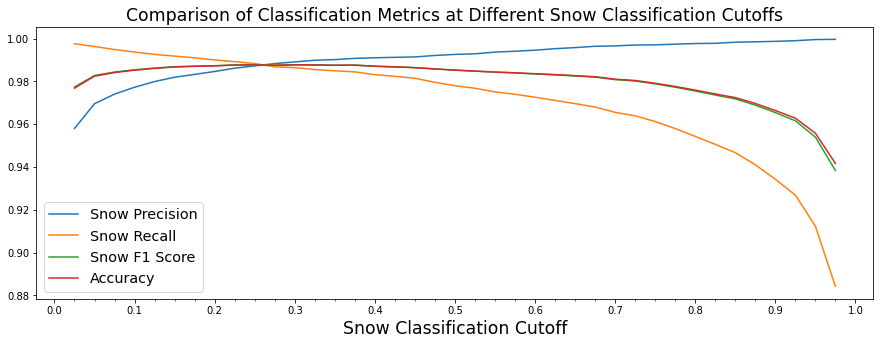

In [7]:
# Plot the precision, recall, f1 score, and accuracty of snow identification for each cutoff.
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(snow_cutoffs, snow_precisions, label='Snow Precision')
ax.plot(snow_cutoffs, snow_recalls, label='Snow Recall')
ax.plot(snow_cutoffs, snow_f1_scores, label='Snow F1 Score')
ax.plot(snow_cutoffs, accuracies, label='Accuracy')
ax.xaxis.set_major_locator(MultipleLocator(.1))
ax.xaxis.set_minor_locator(MultipleLocator(.025))
ax.set_title('Comparison of Classification Metrics at Different Snow Classification Cutoffs', fontsize='xx-large')
ax.set_xlabel('Snow Classification Cutoff', fontsize='xx-large')
ax.legend(fontsize='x-large');

This graph shows how precision, recall, f1 score, and accuracy vary over a wide range of possible cutoff values for snow classification.  All values converge where precision and recall are equal, around a cutoff of about 0.25.  Conveniently, accuracy is also at its maximum near this point, and it drops off only gradually as the cutoff is shifted.  If desired, the cutoff could be shifted lower for an increase in recall at the expense of precision with minimal overall accuracy loss.

In [97]:
zipped = list(zip(snow_cutoffs, accuracies))

cut_high, acc_high = zipped[0]
for cut, acc in zipped[1:]:
    if acc > acc_high:
        acc_high = acc
        cut_high = cut

cut_high,acc_high

(0.24999999999999997, 0.98775)

The above cell confirms that, of the 39 cutoffs checked, 0.25 gives the highest accuracy.

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9777    0.9934    0.9855     39975
        snow     0.9933    0.9773    0.9853     40025

    accuracy                         0.9854     80000
   macro avg     0.9855    0.9854    0.9854     80000
weighted avg     0.9855    0.9854    0.9854     80000

ROC AUC score: 0.9853800255390724

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9781    0.9927    0.9853      9956
        snow     0.9926    0.9780    0.9853     10044

    accuracy                         0.9853     20000
   macro avg     0.9854    0.9853    0.9853     20000
weighted avg     0.9854    0.9853    0.9853     20000

ROC AUC score: 0.985332276032864

*************************



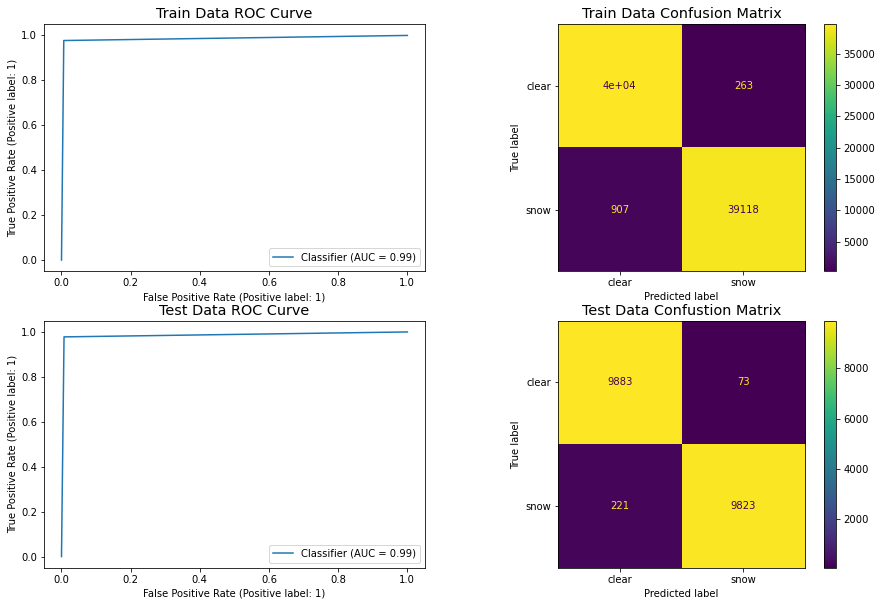

In [98]:
check_cutoff(train_pred_df, val_pred_df, 0.5)

Full classification metrics for the default cutoff of 0.5, as seen in Notebook 1.  Precision significantly exceeds recall when detecting snow, which is likely not ideal for an automated snow detection system in which failure to detect snow is probably worse than falsely detecting snow.

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9883    0.9864    0.9874     39975
        snow     0.9865    0.9883    0.9874     40025

    accuracy                         0.9874     80000
   macro avg     0.9874    0.9874    0.9874     80000
weighted avg     0.9874    0.9874    0.9874     80000

ROC AUC score: 0.9873744013181256

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9882    0.9871    0.9877      9956
        snow     0.9873    0.9884    0.9878     10044

    accuracy                         0.9878     20000
   macro avg     0.9878    0.9877    0.9877     20000
weighted avg     0.9878    0.9878    0.9877     20000

ROC AUC score: 0.9877473427885565

*************************



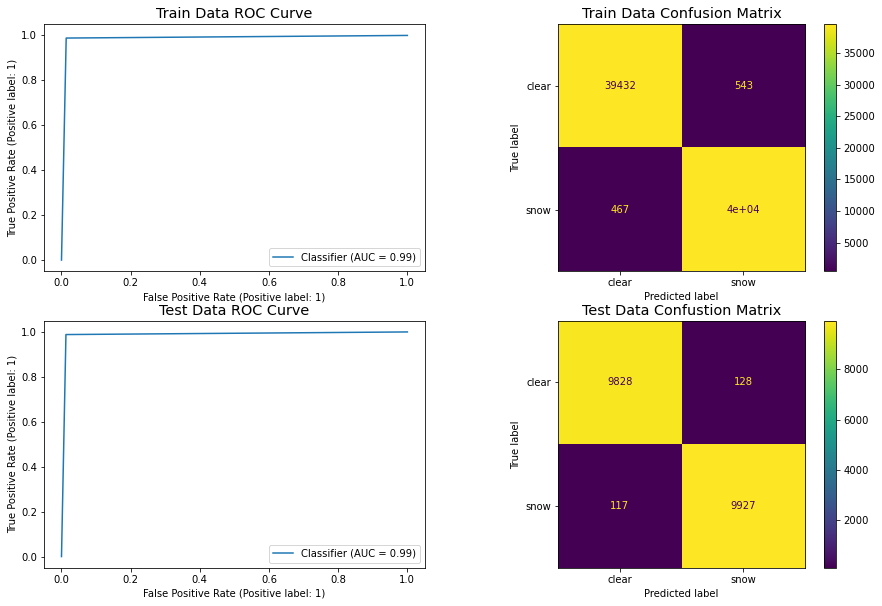

In [99]:
check_cutoff(train_pred_df, val_pred_df, 0.25)

Classification metrics with a cutoff of 0.25.  In addition to a slightly improved overall accuracy, this cutoff gives us nearly identical precision and recall.  If desired, an even lower cutoff can be used to optimize the model for high recall.

I now reload model2.

In [8]:
load_model_name = 'model2'

In [9]:
train_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_train.csv')
val_pred_df = pd.read_csv(f'../saved_models/{load_model_name}_val.csv')

The two cells below are identical to those used above to compare cutoffs.  If the future, they will likely be wrapped into a function to reduce repetition.

In [10]:
snow_cutoffs = []
snow_precisions = []
snow_recalls = []
snow_f1_scores = []
accuracies = []
for snow_cutoff in np.linspace(.025, .975, 39):
    val_pred_df['pred_binary'] = val_pred_df['pred'].apply(binarize_class, args=(snow_cutoff,))
    report = classification_report(val_pred_df['true'], val_pred_df['pred_binary'], target_names=['clear', 'snow'], output_dict=True)
    snow_cutoffs.append(snow_cutoff)
    snow_precisions.append(report['snow']['precision'])
    snow_recalls.append(report['snow']['recall'])
    snow_f1_scores.append(report['snow']['f1-score'])
    accuracies.append(report['accuracy'])

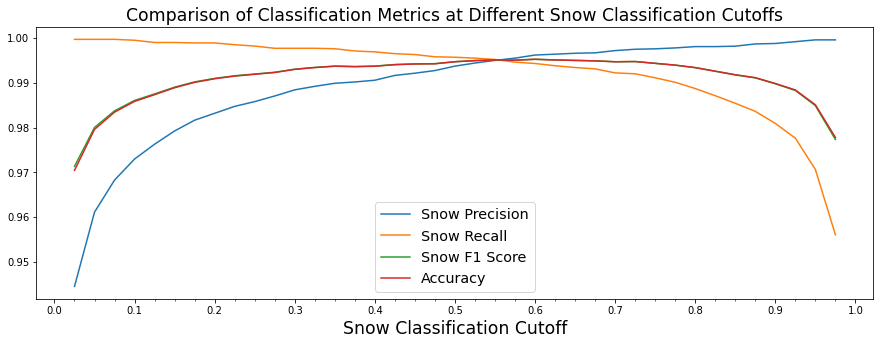

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(snow_cutoffs, snow_precisions, label='Snow Precision')
ax.plot(snow_cutoffs, snow_recalls, label='Snow Recall')
ax.plot(snow_cutoffs, snow_f1_scores, label='Snow F1 Score')
ax.plot(snow_cutoffs, accuracies, label='Accuracy')
ax.xaxis.set_major_locator(MultipleLocator(.1))
ax.xaxis.set_minor_locator(MultipleLocator(.025))
ax.set_title('Comparison of Classification Metrics at Different Snow Classification Cutoffs', fontsize='xx-large')
ax.set_xlabel('Snow Classification Cutoff', fontsize='xx-large')
ax.legend(fontsize='x-large');

The ideal cutoffs for model2 differ significantly from those for test1.  As confirmed in the cell below, the maximum accuracy is now at a cutoff of 0.6  It's possible that model2 has better-centered predictions due to being trained for twice as many epochs.  It's also possible that decreasing the convolution kernel and increaseing the pooling kernel increased the model's sensitivity to snow, as intended.

The cutoff at which precision and recall are equal is even closer to 0.5 than the cutoff that produces maximum accuracy.  In this case, choosing maximum accuracy will result in precision of snow detection being slightly higher than recall.  However, the accuracy dropoff is still slow, with accuracy remaining above 99% for a very wide range of cutoffs.  This allows for the model to be highly tuned to favor precision or recall as the situation requires.

In [106]:
zipped = list(zip(snow_cutoffs, accuracies))

cut_high, acc_high = zipped[0]
for cut, acc in zipped[1:]:
    if acc > acc_high:
        acc_high = acc
        cut_high = cut

cut_high,acc_high

(0.6, 0.99525)

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9963    0.9941    0.9952     40134
        snow     0.9941    0.9963    0.9952     39866

    accuracy                         0.9952     80000
   macro avg     0.9952    0.9952    0.9952     80000
weighted avg     0.9952    0.9952    0.9952     80000

ROC AUC score: 0.9952286314533164

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9957    0.9937    0.9947      9983
        snow     0.9937    0.9957    0.9947     10017

    accuracy                         0.9947     20000
   macro avg     0.9947    0.9947    0.9947     20000
weighted avg     0.9947    0.9947    0.9947     20000

ROC AUC score: 0.9946982846780428

*************************



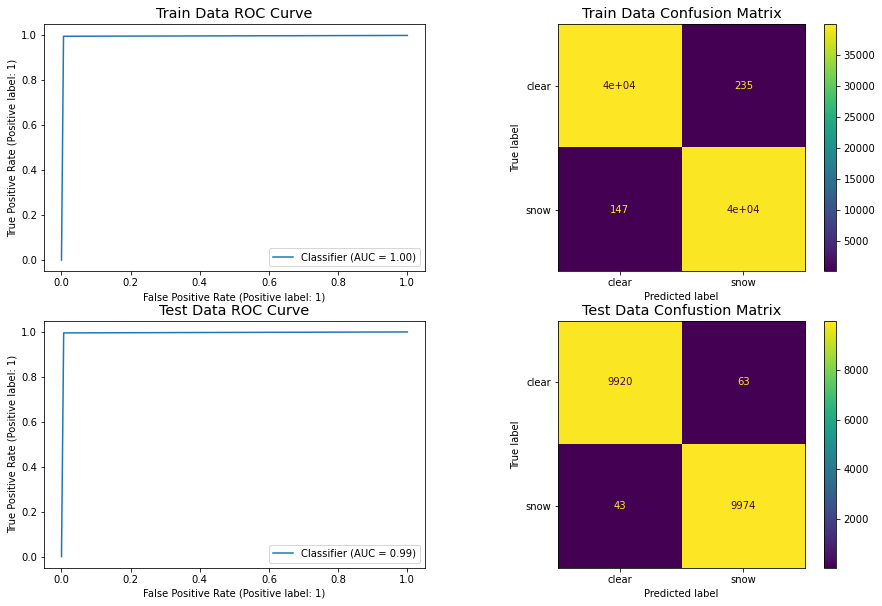

In [108]:
check_cutoff(train_pred_df, val_pred_df, 0.5)

Classification metrics for model2 with the default cutoff of 0.5.  Recall is slighlty higher than precision, but precsion, recall, and accuracy are all comfortably above 99%.

Train Data Metrics:

              precision    recall  f1-score   support

       clear     0.9958    0.9951    0.9954     40134
        snow     0.9950    0.9957    0.9954     39866

    accuracy                         0.9954     80000
   macro avg     0.9954    0.9954    0.9954     80000
weighted avg     0.9954    0.9954    0.9954     80000

ROC AUC score: 0.9954011208890792

*************************

Test Data Metrics:

              precision    recall  f1-score   support

       clear     0.9952    0.9950    0.9951      9983
        snow     0.9950    0.9952    0.9951     10017

    accuracy                         0.9951     20000
   macro avg     0.9951    0.9951    0.9951     20000
weighted avg     0.9951    0.9951    0.9951     20000

ROC AUC score: 0.9950998158384677

*************************



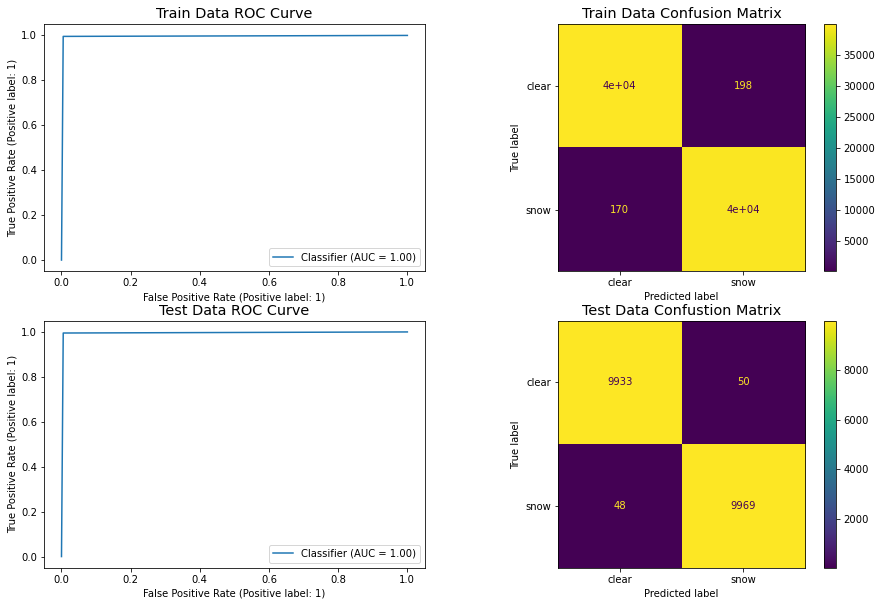

In [110]:
check_cutoff(train_pred_df, val_pred_df, 0.55)

Classification metrics for model2 with a cutoff of 0.55.  This results in an accuracy between those achieved with cutoffs at 0.5 and 0.6 (0.6 providing the max accuracy among all cutoffs tested).  Compared with the cutoff of 0.5, precison improves at the expense of a small amount of recall, and precision and recall are essentially identical.

### Section IX: Recommendations and Future Directions. ###

The models created here have shown great potential for snow detection in images.  For the streamlit app, I will use model2 and a snow classification cutoff of 0.55.  This gives precision, recall, and accuracy of 99.5% on the validation data.  In addition to being slightly better performing, model2 is smaller than test1 at less than 1 MB.  This makes it ideal for deployment on streamlit.

There is great potential for future work in this project.
- The synthetic dataset has advantages.  The fact that the images are identical aside from the apparent snow means that the model cannot classify images based on anything else.  However, the model should be tested in real-world conditions to determine how well it performs with real snow.  Gathering a large amount of such data may not be easy, but public webcams such as traffic cameras could be an excellent place to begin.
- In-depth analysis of the failure cases could be very helpful for understanding the limitations of the model.
- With the models being slightly underfit, there is room for more extensive tuning and training, which could improve the models' performance even further.  This may not be necessary right now, given the small size and high accuracy of the models, but it may be necessary to modify them for future applications, discussed further below.  In that case, further hyperparameter tuning and more training epochs may be useful.  Optimization methods, such as transfer learning, pruning, and quantization, may also be necessary for applications that demand very quick predictions and/or a more complex model.
- The streamlit app that identifies falling snow in a single image can be expanded upon.  A website that uses these models to identify snowfall in a video or a live feed from a webcam via API (likely on a short delay), would greatly expand the possible applications.  Automatic snow detection in a traffic camera could be useful to emergency and transit authorities, or even for ski resorts.  The current models may be quick and small enough for the task, but it may also be necessary to use a more sophisticated model such as YOLO.
- Finally, this project can be taken beyond snow detection.  Prior work in this area includes removal of snow from images using a Generative Adversarial Network, which was the original use for the dataset I have been using in this project.